In [2]:
import pandas as pd
import numpy as np
from scipy.stats import entropy 

import os, pickle, re, glob, time
np.set_printoptions(precision=2)

import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from collections import Counter

sns.set_style('ticks')
pd.set_option('precision', 2)

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import matplotlib as mpl
mpl.rcParams['figure.dpi']= 300
mpl.rc("savefig", dpi=300)

### Calculate ItTH and scItTH scores

In [3]:
ds_name_list = ['AS_et_al', 'SP_et_al']
norm_type = 'tpm' # for this analysis, tpm was used

In [4]:
result_df_list = []

for ds_name in ds_name_list:
    
    sample_tpm_df = pd.read_csv('../preprocessed_data/scRNAseq/{}_sample_avg_log2tpm.tsv'.format(ds_name), index_col=0, sep='\t')
    
    sample_list = sample_tpm_df.columns

    GDSC_decon_df = pd.read_csv('../cibersort/{}_GDSC_subtype_panal_log2tpm_decon_result.tsv'.format(ds_name), index_col=0, header=7, sep='\t')
    # GDSC_decon_df = pd.read_csv('../result/CIBERSORT_deconvolution/cibersort_gdsc_panel_cl_exp.txt', index_col=0, header=8, sep='\t')
    GDSC_decon_df = GDSC_decon_df[GDSC_decon_df.columns[0:-4]]

    GDSC_decon_df.index = sample_list
    GDSC_decon_df = GDSC_decon_df.where(GDSC_decon_df >= 0.05, other=0)

    ITTH = entropy(pk=GDSC_decon_df.T, qk=None)

    ##### Calculate scITTH based on single-cell clustering results

    sc_cluster_df = pd.read_csv('../preprocessed_data/scRNAseq/{}_{}_cluster.csv'.format(ds_name, norm_type), index_col=0)[['sample_id', 'cluster']]

    sample_cnt_df = sc_cluster_df.groupby('sample_id').count()
    sample_cnt_df.columns = ['sample_cnt']

    sample_cluster_cnt_df = sc_cluster_df.reset_index().groupby(['sample_id', 'cluster']).count().reset_index()
    sample_cluster_cnt_df.columns = ['sample_id', 'cluster', 'sample_cluster_cnt']

    merge_df = pd.merge(sample_cluster_cnt_df, sample_cnt_df, left_on='sample_id', right_index=True)
    merge_df.loc[:, 'percent'] = merge_df['sample_cluster_cnt'] / merge_df['sample_cnt']

    cluster_percent_df = merge_df.pivot(index='sample_id', columns='cluster', values='percent').fillna(0)
    cluster_percent_df = cluster_percent_df.where(cluster_percent_df >= 0.05, other=0)

    scITTH = entropy(pk=cluster_percent_df.T, qk=None)

    df = pd.DataFrame(np.array([sample_tpm_df.columns, scITTH, ITTH]).T, columns=['sample_id', 'scITTH', 'ITTH'])
    df.loc[:, 'dataset'] = ds_name
    
    result_df_list += [df]

In [5]:
result_df = pd.concat(result_df_list)
result_df.loc[:, 'ITTH'] = result_df['ITTH'].values.astype(float)
result_df.loc[:, 'scITTH'] = result_df['scITTH'].values.astype(float)

result_df

,sample_id,scITTH,ITTH,dataset
0,HN120M,0.58,1.71,AS_et_al
1,HN120P,0.65,2.00,AS_et_al
2,HN137M,0.99,1.83,AS_et_al
3,HN137P,0.85,2.04,AS_et_al
4,HN137P2,1.08,1.99,AS_et_al
5,HN148M,0.65,2.13,AS_et_al
6,HN148P,0.21,1.24,AS_et_al
7,HN159M,0.00,1.54,AS_et_al
8,HN159P,0.66,2.04,AS_et_al
9,HN160M,0.65,2.04,AS_et_al


AS_et_al SpearmanrResult(correlation=0.49650349650349657, pvalue=0.10060263183225483) (0.5856047489223254, 0.04543323951693408)
SP_et_al SpearmanrResult(correlation=0.5922077922077922, pvalue=0.0046768122311073666) (0.551576285231994, 0.009540719256742705)


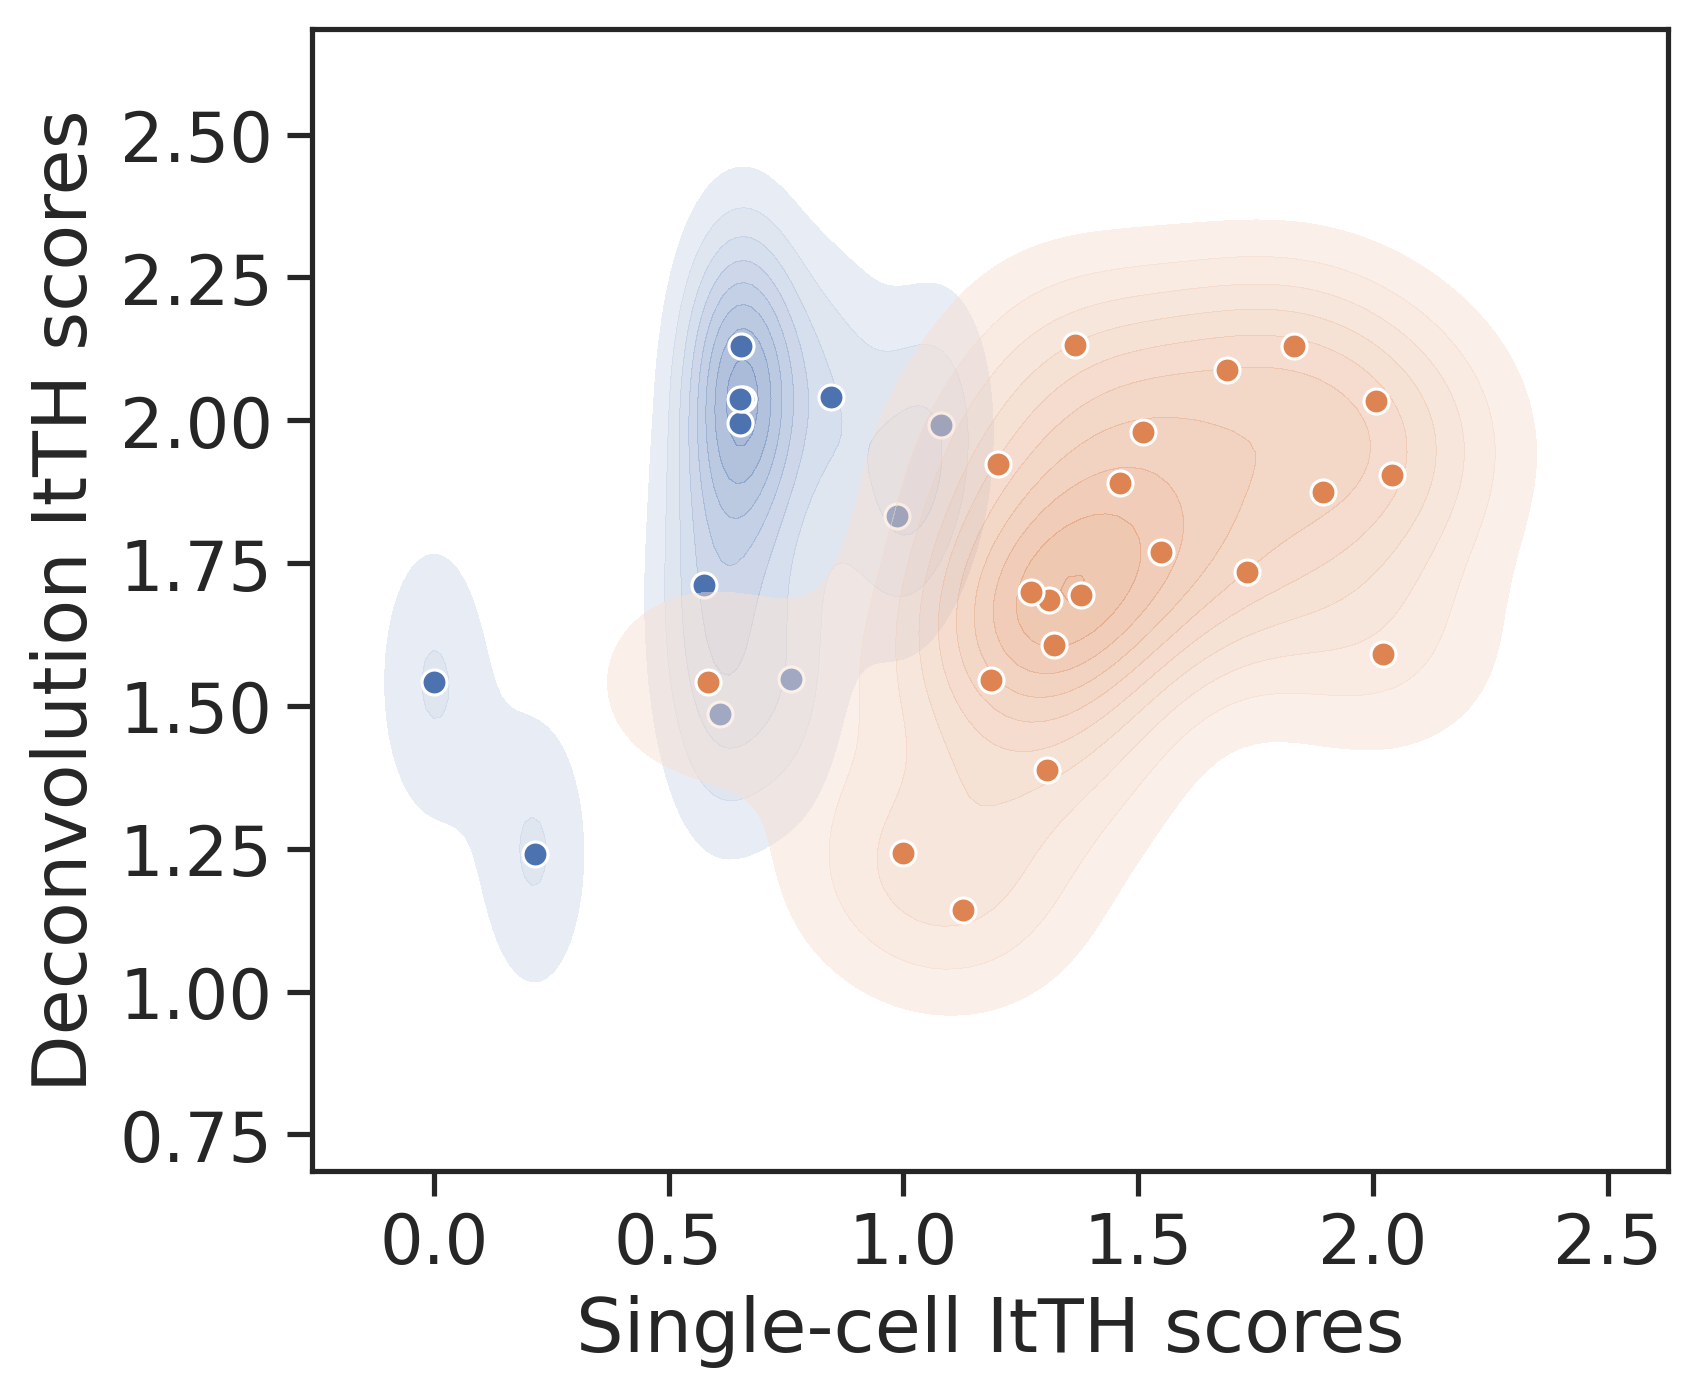

In [6]:
sns.set(style='ticks', font_scale=1.5)
fig, ax = plt.subplots(figsize=(6,5))

for ds_name in ds_name_list:
    ds_result_df = result_df[result_df['dataset']==ds_name]
    sns.kdeplot(ds_result_df['scITTH'], ds_result_df['ITTH'], shade=True, shade_lowest=False, alpha=0.5)
    sns.scatterplot(ds_result_df['scITTH'], ds_result_df['ITTH'])
    print (ds_name, stats.spearmanr(ds_result_df['scITTH'], ds_result_df['ITTH']), stats.pearsonr(ds_result_df['scITTH'], ds_result_df['ITTH']))

plt.xlabel('Single-cell ItTH scores')
plt.ylabel('Deconvolution ItTH scores')

plt.tight_layout()

# plt.savefig('../figure/Figure1A.svg')

AS_et_al SpearmanrResult(correlation=0.49650349650349657, pvalue=0.10060263183225483) (0.5856047489223254, 0.04543323951693408)
SP_et_al SpearmanrResult(correlation=0.5922077922077922, pvalue=0.0046768122311073666) (0.551576285231994, 0.009540719256742705)


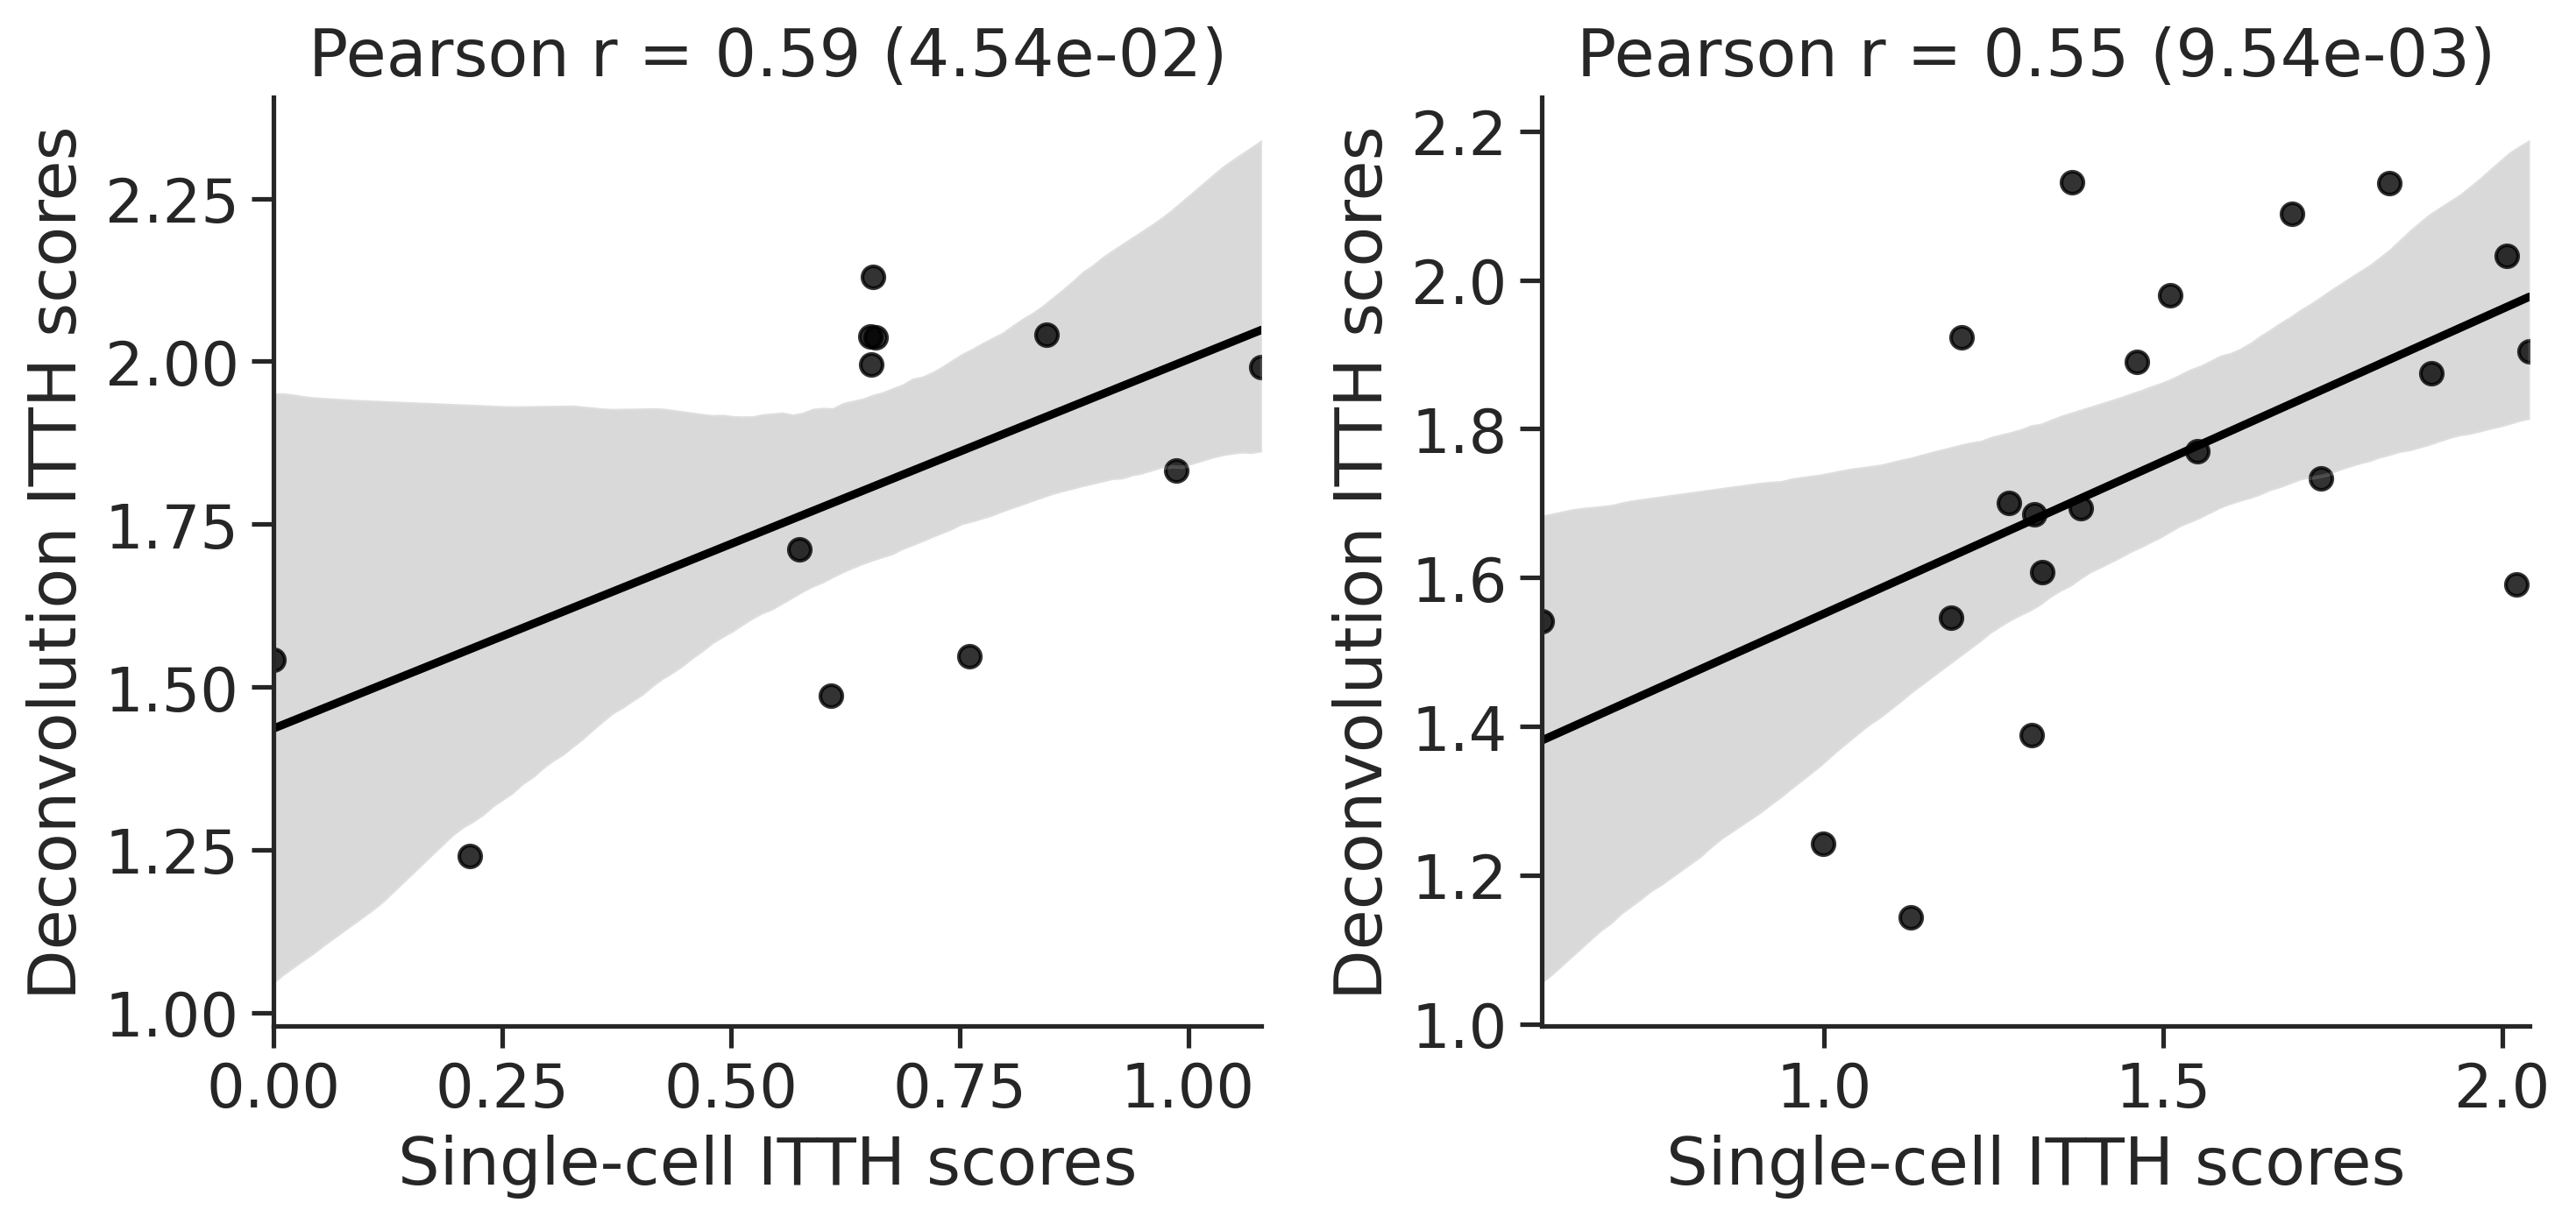

In [9]:
sns.set(style='ticks', font_scale=1.5)
fig, axes = plt.subplots(ncols=2, figsize=(10,5))

for ax, ds_name in zip(axes.flatten(), ds_name_list):
    ds_result_df = result_df[result_df['dataset']==ds_name]
    sns.regplot(data=ds_result_df, x='scITTH', y='ITTH', ax=ax, color='black')
    print (ds_name, stats.spearmanr(ds_result_df['scITTH'], ds_result_df['ITTH']), stats.pearsonr(ds_result_df['scITTH'], ds_result_df['ITTH']))
    pcor, pval = stats.pearsonr(ds_result_df['scITTH'], ds_result_df['ITTH'])
    ax.set_xlabel('Single-cell ITTH scores')
    ax.set_ylabel('Deconvolution ITTH scores')
    ax.set_title('Pearson r = {:.2f} ({:.2e})'.format(pcor, pval))
    sns.despine()

plt.tight_layout()
plt.savefig('../figure/Figure1A.svg')

##### Save scores

In [14]:
result_df.to_csv('../result/ITTH/ITTH_scores_{}.csv'.format(norm_type))